In [1]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers, pickle
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages
import pickle,h5py
from scipy.optimize import curve_fit, minimize
from matplotlib.patches import Rectangle
from scipy.special import erf

In [2]:
base_path = r"F:\data\20240918\3um_SiO2\1\meas"
sphere_data = [r"1",]
cal_path = r"F:\data\20240918\3um_SiO2\1\calibration"
calib_data = [r"1e",]
calib_noise_path = [r"noise",
                    ]

file_label= '20240918'
code_path = r"F:\Jupyter_notebook"
plots_dir = os.path.join(code_path, "plots", file_label)
if(not os.path.isdir(plots_dir)):
    os.makedirs(plots_dir)
data_dir = os.path.join(code_path, "data", file_label)
if(not os.path.isdir(data_dir)):
    os.makedirs(data_dir)

In [3]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

In [4]:
## process data to find charge correlation
importlib.reload(bu)

remake_files = False

num_pts_per_charge_recon = 2**15 ## points to use in each fft segment for charge reconstruction

if(remake_files):
    charge_vec = []
    corr_vec = []
    filament_vec = []
    lamp_vec = []
    for i,f in enumerate(data_list):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        fname = "corr_%d.png"%i
        #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
        curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=num_pts_per_charge_recon,drive_idx=10)
        if(i == 0):
            corr_vec = 1.0*curr_corr_vec
        else:
            corr_vec = np.vstack((corr_vec, curr_corr_vec))

        corr_val = np.median(curr_corr_vec[:,0])

        time = attr["Time"]
        charge_vec.append([time, corr_val])
    
        ## now times lamp and filament are on
        curr_lamp, curr_fil = bu.get_lamp_and_filament(cdat, num_pts_per_charge_recon)
        
        if(i == 0):
            lamp_vec = 1.0*curr_lamp
            filament_vec = 1.0*curr_fil
        else:
            lamp_vec = np.hstack((lamp_vec, curr_lamp))
            filament_vec = np.hstack((filament_vec, curr_fil))

    charge_vec = np.array(charge_vec)
    np.save(data_dir+"/charge_steps_%s.npy"%file_label, charge_vec)
    np.save(data_dir+"/charge_steps_vec_%s.npy"%file_label, corr_vec)
    np.savez(data_dir+"/lamp_filament_data_%s.npz"%file_label, lamp_vec=lamp_vec, filament_vec=filament_vec)
else:
    charge_vec = np.load(data_dir+"/charge_steps_%s.npy"%file_label)
    corr_vec = np.load(data_dir+"/charge_steps_vec_%s.npy"%file_label)

    lfdat = np.load(data_dir+"/lamp_filament_data_%s.npz"%file_label)
    lamp_vec = lfdat["lamp_vec"]
    filament_vec = lfdat["filament_vec"]


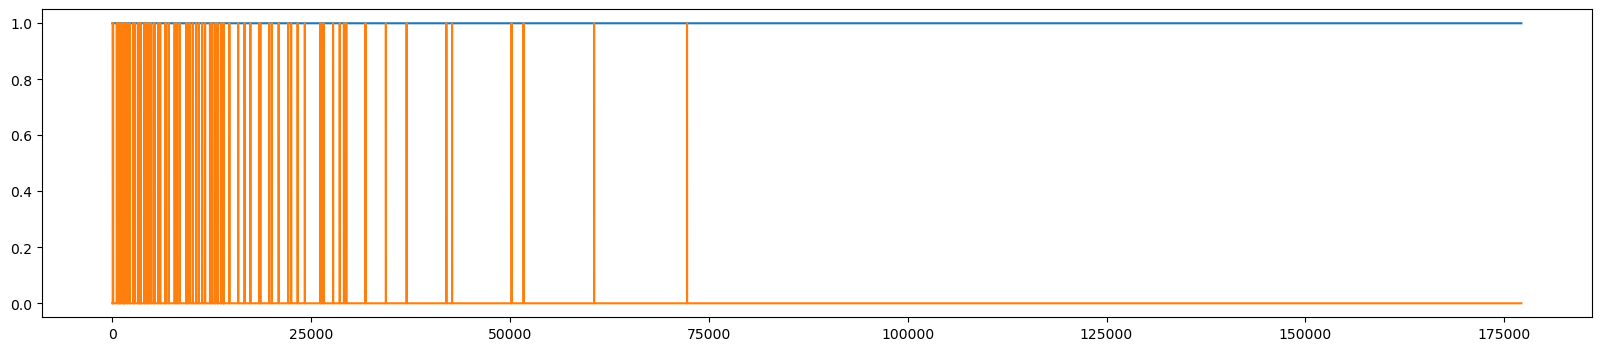

In [5]:
plt.figure(figsize=(20,4))
plt.plot(lamp_vec)
plt.plot(filament_vec)

In [6]:
## Make a list of folder numbers and file names
cdat, attr, fhandle = bu.get_data(data_list[0])
num_pts_per_file = int(len(cdat[:,0])/num_pts_per_charge_recon)
folder_vec = []

for j,f in enumerate(data_list):
    parts = f.split('\\')
    folder_vec.append([int(parts[-2])]*num_pts_per_file)
folder_vec = np.ndarray.flatten(np.array(folder_vec))

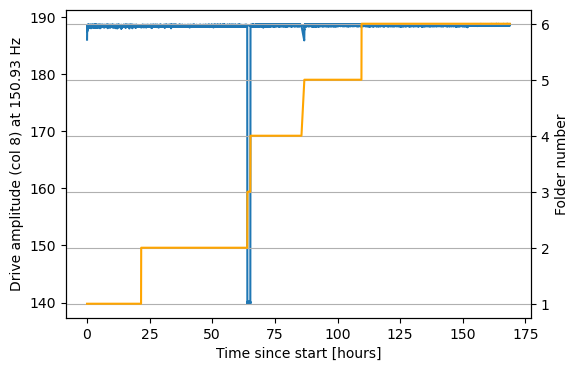

In [7]:
## plot the time correlation with the drive
time_hours = (corr_vec[:,-1]-corr_vec[0,-1])/3600

plt.figure(figsize =(6,4))
plt.plot(time_hours, corr_vec[:,3])
plt.xlabel("Time since start [hours]")
plt.ylabel("Drive amplitude (col 8) at 150.93 Hz")
#plt.ylim(165, 175)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time_hours, folder_vec, color='orange')
plt.ylabel("Folder number")
plt.grid(True)
plt.savefig(plots_dir+"/drive_amp_vs_time.png", dpi=300, bbox_inches='tight')

In [8]:
## initial plot of the charge steps versus time
cal_fac = 0.072 * np.median(corr_vec[:,3])/525 ## scaling to nominal previous calibration factor
corr_idx = 2
recal = np.ones_like(corr_vec[1:,corr_idx])

xmin, xmax = 0, len(corr_vec)
ymin, ymax = -100, 150
init_charge = -25

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

xv = np.arange(len(filament_vec))
plt.fill_between(xv, np.ones_like(filament_vec)*ymin, ymin+np.roll(filament_vec,-1)*(ymax-ymin), color='gray', alpha=0.5)

plt.subplot(2,1,2)
dv = np.diff(corr_vec[:,corr_idx]/cal_fac)
plt.plot(dv)
b,a = sig.butter(1,0.5)
dv2 = sig.filtfilt(b,a,dv)
dv_chopped = np.round(dv)
N=5
dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')
bpts = ((np.abs(dv2) < 2) | (np.abs(dv) < 2)) # | (np.abs(dv) < 0.07*corr_vec[:-1, corr_idx]/cal_fac)
# bpts = None # | (np.abs(dv) < 0.07*corr_vec[:-1, corr_idx]/cal_fac)
dv_chopped[bpts] = 0
# Define the bad ranges
bad_ranges = [(9202,9206), (10056, 10060), (10145, 10149),(10400, 10450),(11350, 11375),(20060, 20180),(20450, 20500),
                (22450,22465),(24075,24100),(25700, 25800),(25950, 26000),(26552, 26575),(26725, 26775),(26850, 26900),
             (30600, 31300),(34100, 34200),(34350, 34375),(36000, 36025),(36050, 36100),(36300, 36310),(36350, 36970),
             (37025, 37050),(37100, 38200),(41500, 41700),(42750, 44450),(44750, 44975),(45400, 45500),(45800, 47450),
             (48350, 48450),(49150, 49450),(49550, 50150),(50200, 50800),(51564, 51675),(51707, 52100),(51707, 52100),
             (52400, 53100),(54342, 54500),(58650, 59050),(60580, 60600),(62300, 62500),(63250, 63350),(64300, 64700),
             (66450, 68650),(70150, 70450),(71400, 71500),(71800, 71875),(71950, 72050),(72259, 76850),(77100, 88150),
             (88650, 88750),(89116, 89250),(90050, 92000),(93550, 93700),(104100, 104150),(109800, 109900),(140000, 141000)]
# Create a boolean mask for all bad ranges
mask = np.zeros_like(dv_chopped, dtype=bool)
for start, end in bad_ranges:
    mask[start:end] = True
# Set the bad points to zero
dv_chopped[mask]=0 # A spike appears, may refine this later
#dv_chopped[dv_chopped > 5] = dv2[dv_chopped > 5]

plt.plot(dv2,color="green")
## fix up missed steps
step_vals = np.loadtxt(data_dir+"/step_locations_%s.txt"%file_label, skiprows=1, delimiter=',')
for i in range(np.shape(step_vals)[0]):
    cvals = step_vals[i,:]
    if(cvals[1] > 0):
        dv_chopped[int(cvals[0]):int(cvals[1])] = cvals[2]
    else:
        dv_chopped[int(cvals[0])] = cvals[2]

plt.plot(dv_chopped,label="chopped data")
plt.legend()
plt.xlim(xmin, xmax)
plt.ylim(-10,10)
plt.grid(True)

running_charge = np.cumsum(dv_chopped) + init_charge
plt.subplot(2,1,1)
plt.plot(running_charge, '-',label='running charge')
plt.legend()
plt.show()

C:\Users\yalem\AppData\Local\Temp\ipykernel_6132\3853338542.py:28: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')

KeyboardInterrupt



In [ ]:
running_charge = np.cumsum(dv_chopped) + init_charge
plt.figure(figsize=(240,32))
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.plot(dv_chopped,label="chopped data")
plt.xlim(110000, 140000)
plt.ylim(-80, 150)
plt.plot(running_charge, '-',label='running charge',alpha=0.5)
plt.grid(True)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(50))
plt.legend()
plt.show()

In [ ]:
running_charge = np.cumsum(dv_chopped) + init_charge
plt.figure(figsize=(129,32))
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.plot(dv_chopped,label="chopped data")
plt.xlim(0, 100)
plt.ylim(-80, 80)
plt.plot(running_charge, '-',label='running charge')
plt.grid(True)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend()
plt.show()

In [ ]:
## initial plot of the charge steps versus time
cal_fac = 0.072 * np.median(corr_vec[:,3])/511.5 ## scaling to nominal previous calibration factor
corr_idx = 2
recal = np.ones_like(corr_vec[1:,corr_idx])
xmin,xmax=53,55
ymin, ymax = -100, 150
init_charge = 11

plt.figure(figsize=(24,16))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(time_hours[:-1],corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xticks(np.arange(xmin, xmax, 1.0))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

In [ ]:
arr=filament_vec>0
count_true = np.sum(filament_vec_new)

print(f"Number of True values: {count_true}")

In [ ]:
print(filament_period_edges)

In [ ]:
importlib.reload(bu)

## make a dead time vector
live_vec = 1.0*time_hours
# bad_pts = (time_hours > 200)| ((time_hours > 53) & (time_hours < 53.25)) | ((time_hours > 57) & (time_hours < 58))| ((time_hours > 57) & (time_hours < 58))\
# | ((time_hours > 60.75) & (time_hours < 61.25))| ((time_hours > 61.75) & (time_hours < 62))\
# | ((time_hours > 63) & (time_hours < 64))| ((time_hours > 65) & (time_hours < 65.25))| ((time_hours > 68) & (time_hours < 69))# (folder_vec == 5) | (time_hours > 55)
bad_pts = (time_hours > 200)
live_vec = live_vec[~bad_pts]

calib_lamp_list = []
calib_lamp = np.zeros_like(time_hours, dtype=bool)
for cl in calib_lamp_list:
    calib_lamp = calib_lamp | ((time_hours>cl[0]) & (time_hours<cl[1])) ## times when the lamp calibration is on
live_vec_lamp = time_hours[~calib_lamp]

## add buffer on either side:
filament_vec_new = filament_vec > 0
filament_vec_new = filament_vec_new | np.roll(filament_vec_new,-1)
live_vec_filament = time_hours[~(filament_vec_new)]

dead_period_edges = bu.get_edges_from_livetime_vec(live_vec, time_hours, [])
lamp_period_edges = bu.get_edges_from_livetime_vec(live_vec_lamp, time_hours, dead_period_edges)
filament_period_edges = bu.get_edges_from_livetime_vec(live_vec_filament, time_hours, dead_period_edges+lamp_period_edges)

print(filament_period_edges)

tot_dead_periods = 0
dead_periods_to_use = [dead_period_edges, lamp_period_edges, filament_period_edges]
for dpe in dead_periods_to_use:
    for dp in dpe:
        tot_dead_periods += dp[1]-dp[0]


tot_livetime = time_hours[-1] - tot_dead_periods
print(time_hours[-1], tot_dead_periods, tot_livetime)    


In [ ]:
## define plotting function for dead times
def fill_dps(dead_period_edges, color='blue', lab="Dead time"):
    yy = plt.ylim()
    for i,dp in enumerate(dead_period_edges):
        if(i==0 and len(lab)>0):
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color=color, alpha=0.2, label=lab)
        else:
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color=color, alpha=0.2)  
    plt.ylim(yy)

In [ ]:
## find the locations of the charge changes
all_bad_periods = dead_period_edges + lamp_period_edges + filament_period_edges
bad_pts = np.zeros_like(time_hours[:-1], dtype=bool)
for dp in all_bad_periods:
    bad_pts = bad_pts | ((time_hours[:-1] >= dp[0]) & (time_hours[:-1] <= dp[1]))

min_change = 1
changes = (dv_chopped < 0) & (np.abs(dv_chopped) > min_change) & ~bad_pts
big_changes = (np.abs(dv_chopped) >= 8) & (dv_chopped > min_change) & ~bad_pts

num_true = np.sum(changes)

print(f"Number of True values: {num_true}")
## group consecutive changes
idx_of_charge_changes = np.where(changes)[0]
dup_changes = np.diff(idx_of_charge_changes) <= 2
good_change_list = [ [time_hours[idx_of_charge_changes[0]], dv_chopped[idx_of_charge_changes[0]], running_charge[idx_of_charge_changes[0]-1]] ] 
for j in range(1,len(idx_of_charge_changes)):
    is_dup = dup_changes[j-1]
    if(is_dup):
        good_change_list[-1][1] += dv_chopped[idx_of_charge_changes[j]]
        continue
    good_change_list.append([time_hours[idx_of_charge_changes[j]], dv_chopped[idx_of_charge_changes[j]], running_charge[idx_of_charge_changes[j]-1]])

good_change_list = np.array(good_change_list)

In [ ]:
non_zero_count = np.count_nonzero(dv_chopped)

print(f"Number of non-zero elements: {non_zero_count}")
count_larger_than_zero = np.sum(dv_chopped > 0)

print(f"Number of elements larger than 0: {count_larger_than_zero}")
count_smaller_than_zero = np.sum(dv_chopped < 0)

print(f"Number of elements smaller than 0: {count_smaller_than_zero}")

In [ ]:
#save the step locations
np.savez(data_dir+"/charge_data_%s.npz"%file_label, time_hours=time_hours, corr_vec=corr_vec, dv_chopped=dv_chopped, running_charge=running_charge, 
         dead_period_edges=dead_period_edges, lamp_period_edges=lamp_period_edges, filament_period_edges=filament_period_edges,cal_fac=cal_fac,corr_idx=corr_idx,
         good_change_list=good_change_list, tot_livetime=tot_livetime, all_bad_periods=all_bad_periods)

In [ ]:
## plot charge changes vs time
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(14, 4), width_ratios=[3,1])

plt.sca(scatter_ax)
#scatter_ax.plot(time_hours[1:][changes], dv_chopped[changes], 'ro', label='Total counts=%d'%np.sum(changes))
scatter_ax.plot(good_change_list[:,0], good_change_list[:,1], 'ko', label='Total counts=%d'%len(good_change_list[:,1]))
ymin, ymax = -75, 5
plt.ylim(ymin,ymax)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.grid(True)
plt.xlim(0, time_hours[-1])
plt.ylabel("Charge change [$e$]")
plt.xlabel("Time since start [hours]")
plt.legend()

hh, be = np.histogram(good_change_list[:,1], bins=30, range=(ymin,ymax))
bc = be[:-1] + np.diff(be)/2
#plt.step(be[:-1], hh, where='post', color='k')
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko')
plt.yticks([])
plt.ylim(ymin,ymax)
plt.xlabel("Counts")
plt.subplots_adjust(wspace=0)

plt.savefig(plots_dir+"/charge_changes_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(good_change_list[:,2], good_change_list[:,1], 'ko')
plt.xlabel("Net charge [$e$]")
plt.ylabel("Charge change [$e$]")
plt.grid(True)
plt.savefig(plots_dir+"/charge_changes_vs_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [ ]:
def lfun(t, N0, t12, tot_time=tot_livetime, use_norm=True, dead_period_edges=all_bad_periods):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12), tint)
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=tot_livetime):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

In [ ]:
t = np.linspace(0, time_hours[-1], 5000)
plt.figure(figsize=(8,6))
plt.plot(t, lfun(t, 1, 10.6))
plt.plot(t, lfun(t, 1, 20))
plt.plot(t, lfun(t, 1, 40))
print(np.trapz(lfun(t, 1, 10.6)),np.trapz(lfun(t, 1, 20)))

In [ ]:
## time of decays/half life
decay_times = good_change_list[:,0] #time_hours[1:][changes]
#big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 1000, 400)
t12_vec = np.linspace(0.5, 30, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
#nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        #nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
#nll_mat_big -= np.min(nll_mat_big)

In [ ]:
t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all,] # nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

fig2d = plt.figure(figsize=(14,5))
params_from_profile = []
for j in range(1):

    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+2)
    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    plt.plot(t12_vec, profile_nll, 'k', label="Fit = $%.1f^{+%.1f}_{-%.1f}$ hr"%(cv, uv-cv, cv-lv))
    plt.ylim(0, 10)
    levels = [1, 4, 9]
    for lidx, l in enumerate(levels):
        plt.plot(t12_vec, l*np.ones_like(t12_vec), 'k--', alpha=0.5)
        plt.text(12, l+0.2, "$%d\sigma$"%(lidx+1), fontsize=9, color='gray')
    plt.plot([t12_true, t12_true], [0, 10], 'b:', label="Pb-212 value = %.1f hr"%t12_true)
    plt.xlim(5,30)
    plt.xlabel("Half-life, $T_{1/2}$ [hr]")
    plt.ylabel("2 $\Delta$NLL")
    plt.legend(loc="upper right")
    plt.title(labs[j])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+1)
    plt.pcolormesh(N0_vec, t12_vec, 2*nlls[j].T, cmap='viridis', vmin=0, vmax=12)
    plt.colorbar(label="2 $\Delta$NLL")
    min_loc = np.argmin(nlls[j].T)
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    plt.plot( np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc], 
             'ro', label="Best fit")

    plt.contour( N0_vec, t12_vec, 2*nlls[j].T, levels=[2.3, 6.17, 11.8], colors='w')
    plt.xlabel("Initial number of nuclei, $N_0$")
    plt.ylabel("Half-life, $T_{1/2}$ [hr]")
    plt.plot(N0_vec, t12_true*np.ones_like(N0_vec), 'k:', label="Pb-212 value = %.1f hr"%t12_true)
    plt.title(labs[j])

    ## plot the profile
    plt.plot(profile, t12_vec, 'r--', label= "Profile")
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

    plt.legend(loc='lower right', fontsize=9)

#plt.figure(fig1d.number)
#plt.savefig(plots_dir+"/profile_1d_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.figure(fig2d.number)
plt.savefig(plots_dir+"/profile_2d_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
nbins = int(tot_livetime/3) + 2

decay_times_list = [decay_times,] # big_decay_times]

plt.figure(figsize=(6,5))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    #plt.subplot(1,2,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,time_hours[-1],1000)
    yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])

    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    #fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,time_hours[-1])
    plt.title(labs[j])
    plt.legend()

plt.savefig(plots_dir+"/decays_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [ ]:
plt.figure(figsize=(14,10))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,int(time_hours[-1])))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    plt.subplot(2,1,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,time_hours[-1],1000)
    yy = np.log(2)*bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = np.log(2)*bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = np.log(2)*bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])

    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    #fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,time_hours[-1])
    plt.title(labs[j])
    plt.legend()

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps(dead_period_edges)
fill_dps(lamp_period_edges, 'black', lab="UV lamp")
fill_dps(filament_period_edges, 'red', lab="Filament")
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="lower right")
plt.xlim(0,time_hours[-1])

plt.savefig(plots_dir+"/decays_vs_time_with_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [ ]:
det_change_list = [ [idx_of_charge_changes[0], dv_chopped[idx_of_charge_changes[0]], running_charge[idx_of_charge_changes[0]-1]] ] 
for j in range(1,len(idx_of_charge_changes)):
    is_dup = dup_changes[j-1]
    if(is_dup):
        good_change_list[-1][1] += dv_chopped[idx_of_charge_changes[j]]
        continue
    det_change_list.append([idx_of_charge_changes[j], dv_chopped[idx_of_charge_changes[j]], running_charge[idx_of_charge_changes[j]-1]])

det_change_list = np.array(det_change_list)

In [ ]:
event_file=np.array(idx_of_charge_changes//4)
event_file=[int(x) for x in event_file]

In [ ]:
print(event_file)

In [ ]:
# all_integers = all(isinstance(x, int) for x in event_file)

# if all_integers:
#     print("The array is made of integers.")
# else:
#     print("The array contains non-integer elements.")

In [ ]:
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
refname = r"LPmbar_xyzcool_55.h5"
fname0 = r"LPmbar_xyzcool_55.h5"
path = r"F:\data\20240918\3um_SiO2\1\meas\1"
Fs=10000
filelist = glob.glob(os.path.join(path , "*.h5"))
filelist = sorted(filelist, key=os.path.getmtime)
data0,time0 = getdata(os.path.join(path, fname0))
if refname:
	data1,time1 = getdata(os.path.join(path, refname))
# PXI1Slot3/ai0:3,PXI1Slot3/ai6:7,PXI1Slot3/ai16:21
plt.rcParams["figure.figsize"] = (18, 9)
if True:	
        time=np.array(np.arange(len(data0[:,3])))/Fs
        fig = plt.figure()
        plt.plot(time,highpass_filter(data0[:,3] - np.mean(data0[:, 3]), 10, Fs, order=3))
        #plt.plot(time,sp.filtfilt(b,a,data0[1][:,bu.xi]))
        if(refname):
                plt.plot(time,highpass_filter(data1[:, 3] - np.mean(data1[:, 3]), 10, Fs, order=3),label="Trigger")
        plt.grid(True)
        plt.legend(loc=1)
        plt.ylabel("V")
        plt.xlabel("Time[s]")

In [ ]:
data_list=np.array(data_list)
event_list=data_list[event_file]
charge_vec = []
corr_vec = []
filament_vec = []
lamp_vec = []
num_pts_per_charge_recon_detailed=2**11
event_list_uq = []
[event_list_uq.append(x) for x in event_list if x not in event_list_uq]
for i,f in enumerate(event_list_uq):
    parts = f.split("\\")
    # Extract the part after the second backslash
    file_title = parts[-2:] if len(parts) > 2 else None
#     f=r"F:\data\20240918\3um_SiO2\1\meas\1\LPmbar_xyzcool_0.h5"
    if(i%10 == 0): print("working on file %d: %s"%(i, f))
    cdat, attr, fhandle = bu.get_data(f)
    if(not fhandle):
        continue    

    fname = "corr_%d.png"%i
    #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
    curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=num_pts_per_charge_recon_detailed,drive_idx=10)
    if(i == 0):
        corr_vec = 1.0*curr_corr_vec
    else:
        corr_vec = np.vstack((corr_vec, curr_corr_vec))

    corr_val = np.median(curr_corr_vec[:,0])

    time = attr["Time"]
    charge_vec.append([time, corr_val])

    ## now times lamp and filament are on
    curr_lamp, curr_fil = bu.get_lamp_and_filament(cdat, num_pts_per_charge_recon)

    if(i == 0):
        lamp_vec = 1.0*curr_lamp
        filament_vec = 1.0*curr_fil
    else:
        lamp_vec = np.hstack((lamp_vec, curr_lamp))
        filament_vec = np.hstack((filament_vec, curr_fil))
    time_sec = (curr_corr_vec[:,-1]-curr_corr_vec[0,-1])
    time=np.array(np.arange(len(cdat[:,3])))/Fs
    plot_charge=curr_corr_vec[:,corr_idx]/cal_fac*12.5*np.ones_like(curr_corr_vec[:,corr_idx])
    charge_diff=np.diff(plot_charge)
    charge_diff = np.insert(charge_diff, 0, 0)
    plot_trigger=highpass_filter(cdat[:,3] - np.mean(cdat[:, 3]), 10, Fs, order=3)
    fig = plt.figure()
    plt.title(f'Plot {i} from {file_title}')
    plt.plot(time_sec,plot_charge,label="Charge Monitor")
    plt.plot(time_sec,charge_diff,label="Charge Monitor")
    plt.plot(time,np.median(plot_charge)/0.05*plot_trigger,label="CAEN trigger")
    plt.grid(True)
    plt.legend(loc=1)
    plt.ylabel("Charge[e]")
    plt.xlabel("Time[s]")
    plt.show()
charge_vec = np.array(charge_vec)

In [ ]:
time_sec = (corr_vec[:,-1]-corr_vec[0,-1])
time=np.array(np.arange(len(data0[:,3])))/Fs
fig = plt.figure()
plt.plot(time_sec,corr_vec[:,corr_idx]/cal_fac*np.ones_like(corr_vec[:,corr_idx]))
plt.plot(time,10*highpass_filter(data0[:,3] - np.mean(data0[:, 3]), 10, Fs, order=3))
plt.grid(True)
plt.legend(loc=1)
plt.ylabel("V")
plt.xlabel("Time[s]")
plt.xlim(2,6)
plt.show()

In [ ]:
def find_time(time_pin,data, trigger):
    data=np.abs(data)
    time=np.array(np.arange(len(data)))/Fs
    peaks, properties = find_peaks(data, height=trigger,distance=10)
    peak_values = data[peaks]
    peak_times = -np.max(time)+time[peaks] + (time_pin-2082844800) #1904->1970
    times=time[peaks]
#     print(time[peaks])
    return peak_times,peak_values,times

In [ ]:
time_data=[]
voltage_total=[]
peak_times_DAQ=[]
peak_values_DAQ=[]
cfile=filelist[382]
data,time = getdata(cfile)
voltage=np.array(highpass_filter(data[:, 3], 10, Fs, order=3))
peak_times_DAQ_temp,peak_values_DAQ_temp,times_temp=find_time(time,highpass_filter(data[:, 3], 10, Fs, order=3), 0.05)
plt.figure(figsize=(128,32))
plt.plot(np.array(np.arange(len(voltage)))/10000,voltage)
DAQ_trig = np.isin(np.array(np.arange(len(voltage)))/10000, times_temp).astype(int)
CAEN_trig=np.isin(np.array(np.arange(len(voltage)))/10000, np.round(trg_time_total,4)).astype(int)

plt.scatter(times_temp[:140],peak_values_DAQ_temp[:140],color='red',label='DAQ')
plt.scatter(trg_time_total[:140],50*voltage[np.array(trg_time_total[:140].astype(int))],color='orange',label='CAEN')
plt.grid(True)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.01))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.005))
plt.legend()
#     plt.xlim(400000,400000)
plt.xlabel('t(s)', {'size': 20})
plt.ylabel('Noise[V]', {'size': 20})
plt.xlim(2,5)
plt.show()
print(len(peak_times_DAQ_temp),"peaks")
peak_times_DAQ=np.concatenate([peak_times_DAQ, peak_times_DAQ_temp])
peak_values_DAQ=np.concatenate([peak_values_DAQ, peak_values_DAQ_temp])
voltage_total=np.concatenate([voltage_total, voltage])

In [ ]:
def read_SIPM_time(detector_list,detector_file_name):
        ovs_dict = {}

        fsample = 62.5e6 ## sampling rate in Hz
        record_length = 129 ## not clear why this differs from the 128 set above
        time_vec = np.arange(0, record_length/fsample, 1/fsample)

        for j,filename in enumerate(filename_list):

            data_dict = {}
            event_time_3=[]
            acq_time_3=[]
            trg_time_3=[]
            wfidx = 0
            with open(detector_file_name, 'rb') as fin:
                print(detector_file_name)
                curr_dict = pickle.load(fin)
                curr_dict=curr_dict[0]
                for wf in curr_dict:

                    sum_waveform = np.zeros_like(time_vec)	

                    ## subtract baseline
                    baseline = 2048 
                    channel_dict = {}
                    for k, ch in enumerate(range(16,-1,-2)):
                        channel_dict[k] = wf[ch] - baseline
                        sum_waveform += (wf[ch] - baseline)

                    channel_dict[9] = sum_waveform

                    data_dict[wfidx] = channel_dict
                    acq_time_temp=wf[17][0]
                    event_time_temp=acq_time_temp+wf[18]/(124999552)
                    acq_time_3.append(acq_time_temp)
                    event_time_3.append(event_time_temp)
                    trg_time_3.append(wf[18]/(124999552))
                    wfidx += 1
            nwaveforms = wfidx
            print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_file_list) + filename)
            data_dict['time'] = time_vec*1e9

            ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict,'event_time':event_time_3,'acq_time':acq_time_3,'trg_time':trg_time_3}
        return ovs_dict

In [ ]:
cf=detector_list[382]
time_data=[]
voltage_total=[]
peak_times_DAQ=[]
peak_values_DAQ=[]
num_pts_per_charge_recon_detailed=2**9
ovs_dict=read_SIPM_time(detector_list,cf)
trg_time_total=np.array(ovs_dict[ov_list[0]]['trg_time'])
cfile=data_list[int(detector_list.index(cf))]
data,time_file = getdata(cfile)
cdat, attr, fhandle = bu.get_data(cfile)
time=np.array(np.arange(len(data[:,3])))/Fs
curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=num_pts_per_charge_recon_detailed,drive_idx=10)
time_sec = (curr_corr_vec[:,-1]-curr_corr_vec[0,-1])+num_pts_per_charge_recon_detailed/(2*Fs)
voltage=np.array(highpass_filter(data[:, 3], 10, Fs, order=3))
peak_times_DAQ_temp,peak_values_DAQ_temp,times_temp=find_time(time_file,highpass_filter(data[:, 3], 10, Fs, order=3), 0.05)
DAQ_trig = np.isin(np.array(np.arange(len(voltage)))/10000, times_temp).astype(int)
CAEN_trig=np.isin(np.array(np.arange(len(voltage)))/10000, np.round(trg_time_total,4)).astype(int)
correlation = np.correlate(DAQ_trig, CAEN_trig, mode='full')
lags = np.arange(-len(DAQ_trig) + 1, len(DAQ_trig))
corr_peaks, _ = find_peaks(correlation,prominence=np.sum(CAEN_trig)/2)
peak_values = correlation[corr_peaks]
delay=lags[corr_peaks]
print(delay)
trg_time_total=trg_time_total+delay/Fs
plot_trigger=highpass_filter(data[:,3] - np.mean(data[:, 3]), 10, Fs, order=3)
plot_charge=curr_corr_vec[:,corr_idx]/cal_fac*12.5*np.ones_like(curr_corr_vec[:,corr_idx])
fig = plt.figure()
plt.plot(time_sec,plot_charge,label="Charge Monitor")
plt.plot(time,0.5*np.median(plot_charge)/0.05*plot_trigger,label="CAEN trigger")
plt.grid(True)
plt.xlim(7,8)
plt.legend(loc=1)
plt.ylabel("Charge[e]")
plt.xlabel("Time[s]")
plt.show()

In [ ]:
def exp_fun(x, A, t12=10.6):
    lam = np.log(2)/t12
    return A*np.exp(-lam*x)

In [ ]:
time_between = np.diff(good_change_list[:,0])

plt.figure(figsize=(6,5))
plt.semilogy(good_change_list[:,0][:-1], time_between*60, 'ko')
plt.xlim(0,time_hours[-1])
plt.ylim(0.1,1e3)
t12_tl208 = 3.1
for i in range(1,4):
    plt.plot([0,time_hours[-1]], [i*t12_tl208, i*t12_tl208], 'k:', alpha=0.5)
    if(i==1):
        plt.text(time_hours[-1]*0.9, i*t12_tl208*1.1, r"$%d \times T_{1/2}^{208Tl}$"%(i), fontsize=9, color='k')
    else:
        plt.text(time_hours[-1]*0.9, i*t12_tl208*1.1, r"$%d \times$"%(i), fontsize=9, color='k')

xcut, ycut = 10, 6.2

all_times = good_change_list[:,0][:-1]
cut_pos = (all_times > xcut) & (time_between*60 < ycut)
bi_decay_times = all_times[cut_pos]
cand_decay_times = all_times[np.roll(cut_pos,1)]


plt.plot( [xcut,xcut], [0.1, ycut], 'b')
plt.plot( [xcut,time_hours[-1]], [ycut, ycut], 'b')
plt.xlabel("Time since start [hours]")
plt.ylabel("Time between decays [minutes]")

plt.savefig(plots_dir+"/time_between_tl208_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
tbins = np.linspace(6,200,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2
bsize_orig = be[1]-be[0]

err = np.sqrt(hh)
err[err==0] = 1
bp, bcov = opt.curve_fit(exp_fun, bc, hh, p0=[20, 20], sigma=err)
print("T12 = %.1f +/- %.1f"%(bp[1], np.sqrt(bcov[1,1])))
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp), 'r')
plt.gca().set_yscale("log")
plt.ylim(0.1,100)
plt.xlabel("Time between decays [m]")
plt.ylabel("Counts")
plt.title("Time between decays (all data)")

plt.subplot(1,2,2)
tbins = np.linspace(0,60,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2

bsize_fac = (be[1]-be[0])/bsize_orig
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp)*bsize_fac, 'r')
#plt.gca().set_yscale("log")
plt.ylim(0,100)
plt.xlabel("Time between decays [m]")
plt.ylabel("Counts")
plt.title("Time between decays (zoom to short times)")

plt.savefig(plots_dir+"/time_between_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


Now let's analyze whether there are any kicks correlated with the charge changes: